In [10]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from utils.encoder_utils import *
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [ ]:
def plot_pca(transition_dim, role="prey", cluster=10):
    scaler = StandardScaler()
    trans_fit = scaler.fit_transform(transition_dim)

    # PCA fit (alle Komponenten, damit Screeplot Sinn macht)
    pca = PCA(n_components=min(trans_fit.shape[0], trans_fit.shape[1]), random_state=0)
    X_pca = pca.fit_transform(trans_fit)

    expl = pca.explained_variance_ratio_
    cumexpl = np.cumsum(expl)

    # Components for 90% variance explanation
    k90 = int(np.searchsorted(cumexpl, 0.90) + 1)
    print("Components for 90% variance:", k90)

    x = np.arange(1, len(expl) + 1)

    plt.figure(figsize=(8, 4.5))
    plt.plot(x, expl, marker='o', label="Explained variance ratio")
    plt.plot(x, cumexpl, marker='o', label="Cumulative explained variance")
    plt.xlabel("Component")
    plt.ylabel("Variance")
    plt.title(f"[{role.upper()}] Scree Plot (PCA)")
    plt.ylim(0, 1.02)
    plt.legend()
    plt.tight_layout()
    plt.show()

    gmm = GaussianMixture(n_components=cluster, covariance_type="full", random_state=0)
    labels = gmm.fit_predict(X_pca)

    X_3d = X_pca[:, :3]

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection="3d")

    sc = ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=labels, s=15)

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title("Clusters in Transition Space")

    plt.tight_layout()
    plt.show()


def cluster_count(transitions, pca_components=12, n_fits=20, model="gmm"):
    pca = PCA(n_components=pca_components, random_state=0)
    X_pca = pca.fit_transform(transitions)

    aic_list = []
    bic_list = []

    for i in tqdm(range(n_fits)):
        if model == "gmm":
            gmm = GaussianMixture(n_components=i+1, covariance_type="full", random_state=0)
            gmm.fit(X_pca)

            aic = gmm.aic(X_pca)
            bic = gmm.bic(X_pca)
        else:
            kmeans = KMeans(n_clusters=i+1, random_state=0)
            kmeans.fit(X_pca)

            inertia = kmeans.inertia_
            n_samples, n_features = X_pca.shape
            n_clusters = i + 1

            aic = inertia + 2 * n_clusters * n_features
            bic = inertia + np.log(n_samples) * n_clusters * n_features

        aic_list.append(aic)
        bic_list.append(bic)

    ks = np.arange(1, n_fits + 1)
    plt.figure(figsize=(7, 4))
    plt.plot(ks, aic_list, marker="o", label="AIC")
    plt.plot(ks, bic_list, marker="o", label="BIC")
    plt.xlabel("Number of components")
    plt.ylabel("Information criterion")
    plt.title(f"Model selection")
    plt.legend()
    plt.tight_layout()
    plt.show()


def calculate_cluster_metrics(model, pca_fit, labels):
    db = davies_bouldin_score(pca_fit, labels)
    print("Davies–Bouldin:", db)

    ch = calinski_harabasz_score(pca_fit, labels)
    print("Calinski–Harabasz:", ch)

    sil = silhouette_score(pca_fit, labels)
    print("Silhouette score:", sil)

    ll = model.score(pca_fit)   # mean log-likelihood
    print("Avg log-likelihood:", ll)

    probs = model.predict_proba(pca_fit)
    entropy = -np.sum(probs * np.log(probs + 1e-8), axis=1)
    print("Mean entropy:", entropy.mean())

    centers = model.means_
    center_dists = pdist(centers)
    print("Mean center distance:", center_dists.mean())


    counts = np.bincount(labels)
    freqs = counts / counts.sum()
    print("Cluster frequencies:", freqs)
    print("Std of frequencies:", freqs.std())

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

window_len = 10
window_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\windows\{window_len} windows'
init_pool_path = rf'..\data\1. Data Processing\processed\init_pool'

pred_files = []
prey_files = []

for file in os.listdir(window_path):
    if file.startswith("pred"):
        pred_tensor = torch.load(os.path.join(window_path, file))
        pred_files.append(pred_tensor)
    elif file.startswith("prey"):
        prey_tensor = torch.load(os.path.join(window_path, file))
        prey_files.append(prey_tensor)

exp_pred_tensor = torch.cat(pred_files, dim=0).type(torch.float32).to(device)
exp_prey_tensor = torch.cat(prey_files, dim=0).type(torch.float32).to(device)

print("Pred Tensor Shape:", exp_pred_tensor.shape)
print("Prey Tensor Shape:", exp_prey_tensor.shape)

Pred Tensor Shape: torch.Size([793, 10, 1, 32, 5])
Prey Tensor Shape: torch.Size([793, 10, 32, 32, 6])


In [4]:
aug = TrajectoryAugmentation(noise_std=0.01, neigh_drop=0.10, feat_drop=0.05).to(device)

prey_encoder = TransitionEncoder(features=5, embd_dim=32, z=32).to(device)
prey_projector = VicRegProjector(input_dim=64).to(device)
prey_optimizer = torch.optim.Adam(list(prey_encoder.parameters()) + list(prey_projector.parameters()), lr=1e-3, weight_decay=1e-6)
train_encoder(prey_encoder, prey_projector, aug=aug, exp_tensor=exp_prey_tensor, epochs=1500, optimizer=prey_optimizer, role="prey")

for p in prey_encoder.parameters():
    p.requires_grad = False 

print("Prey Encoder trained & frozen.\n")

pred_encoder = TransitionEncoder(features=4, embd_dim=32, z=32).to(device)
pred_projector = VicRegProjector(input_dim=64).to(device)
pred_optimizer = torch.optim.Adam(list(pred_encoder.parameters()) + list(pred_projector.parameters()), lr=1e-3, weight_decay=1e-6)
train_encoder(pred_encoder, pred_projector, aug=aug, exp_tensor=exp_pred_tensor, epochs=1000, optimizer=pred_optimizer, role="predator")

for p in pred_encoder.parameters():
    p.requires_grad = False

print("Predator Encoder trained & frozen.")

epoch 010: loss=23.209427 sim=0.0532 std=1.3547 cov=0.3116 std_mean=0.323
epoch 020: loss=22.206291 sim=0.0380 std=1.2632 cov=0.4618 std_mean=0.368
epoch 030: loss=21.593550 sim=0.0356 std=1.2424 cov=0.4134 std_mean=0.379
epoch 040: loss=20.927059 sim=0.0349 std=1.1915 cov=0.4362 std_mean=0.404
epoch 050: loss=20.512016 sim=0.0410 std=1.1390 cov=0.4804 std_mean=0.431
epoch 060: loss=20.272137 sim=0.0406 std=1.1104 cov=0.5201 std_mean=0.445
epoch 070: loss=19.761080 sim=0.0397 std=1.0716 cov=0.5389 std_mean=0.464
epoch 080: loss=19.507778 sim=0.0413 std=1.0616 cov=0.5103 std_mean=0.469
epoch 090: loss=19.390646 sim=0.0453 std=1.0278 cov=0.5682 std_mean=0.486
epoch 100: loss=19.163759 sim=0.0448 std=1.0315 cov=0.5144 std_mean=0.484
epoch 110: loss=18.968136 sim=0.0467 std=0.9994 cov=0.5622 std_mean=0.500
epoch 120: loss=19.360466 sim=0.0499 std=1.0093 cov=0.5946 std_mean=0.495
epoch 130: loss=18.711533 sim=0.0501 std=0.9672 cov=0.5899 std_mean=0.516
epoch 140: loss=18.615458 sim=0.0465 s

In [5]:
scaler = StandardScaler()
prey_states = exp_prey_tensor[..., :5]
_, trans_prey = prey_encoder(prey_states)
x_prey = trans_prey.detach().cpu().numpy()
prey_trans_dim = x_prey.reshape(-1, x_prey.shape[-1])
scaled_prey = scaler.fit_transform(prey_trans_dim)

pred_states = exp_pred_tensor[..., :4]
_, trans_pred = pred_encoder(pred_states)
x_pred = trans_pred.detach().cpu().numpy()
pred_trans_dim = x_pred.reshape(-1, x_pred.shape[-1])  
scaled_pred = scaler.fit_transform(pred_trans_dim)

## Prey

Components for 90% variance: 12


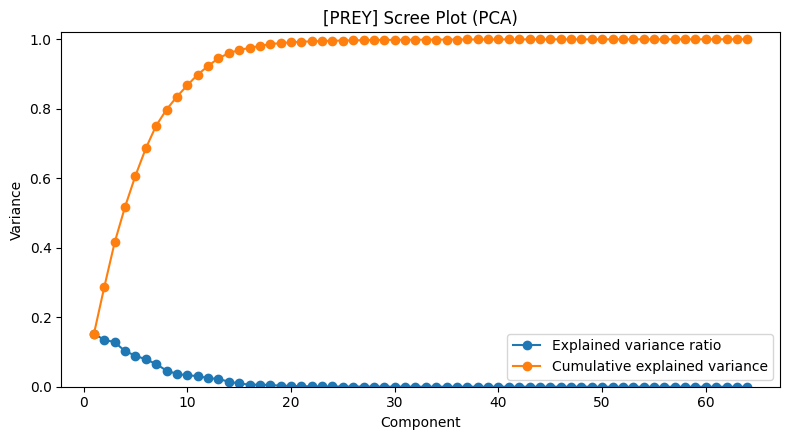

c:\Users\janni\anaconda3\envs\GAIL\lib\site-packages\sklearn\mixture\_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


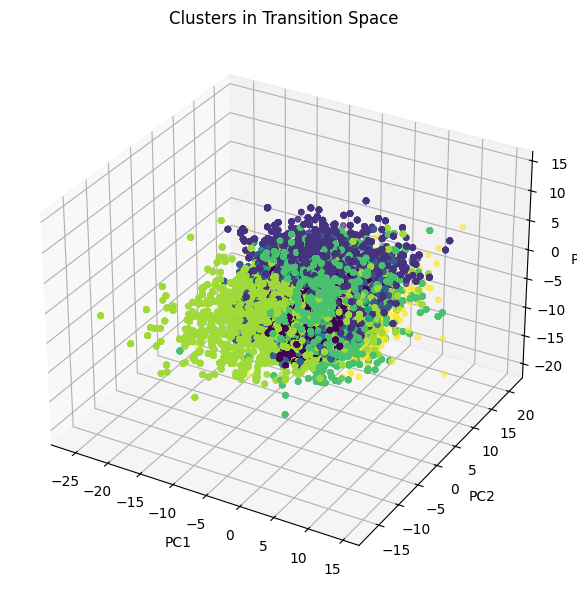

In [6]:
plot_pca(prey_trans_dim, role="prey", cluster=8)

100%|██████████| 20/20 [06:41<00:00, 20.09s/it]


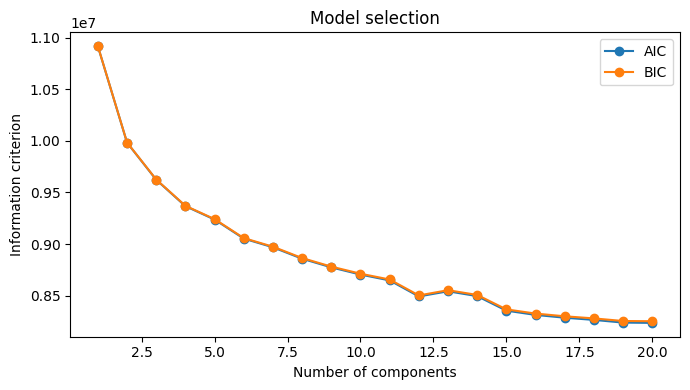

In [7]:
cluster_count(scaled_prey, pca_components=11, n_fits=20, model="gmm")

100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


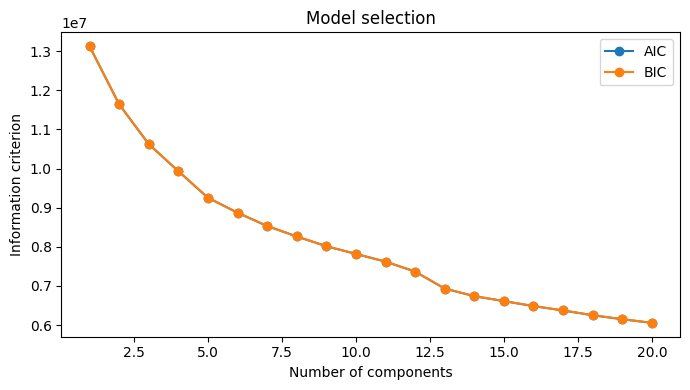

In [8]:
cluster_count(scaled_prey, pca_components=11, n_fits=20, model="kmeans")

In [ ]:
pca = PCA(n_components=11, random_state=0)
X_pca = pca.fit_transform(scaled_prey)

gmm = GaussianMixture(n_components=8, covariance_type="full", random_state=0)
labels = gmm.fit_predict(X_pca)

calculate_cluster_metrics(gmm, X_pca, labels)

Davies–Bouldin: 3.722202075855113
Calinski–Harabasz: 7025.25390625


## Predator

Components for 90% variance: 9


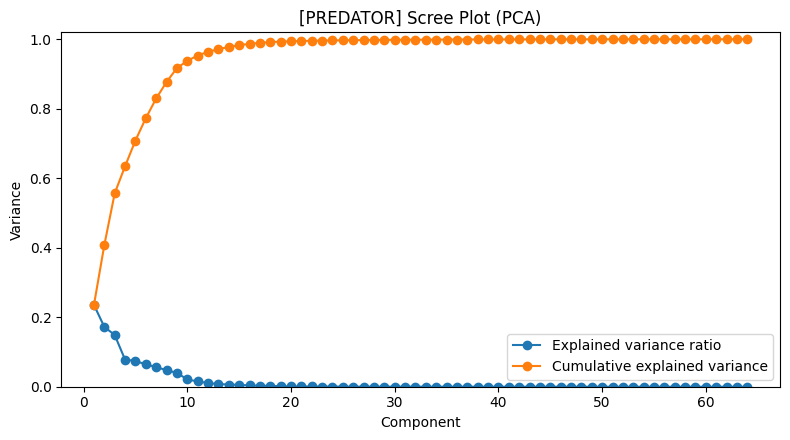

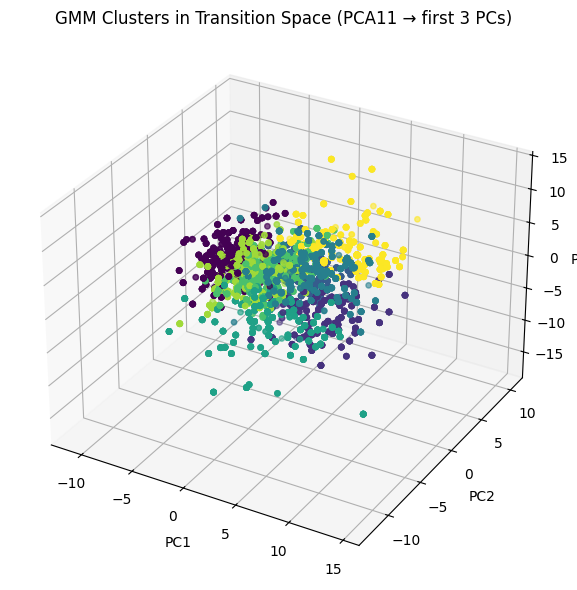

In [ ]:
# Predator
plot_pca(pred_trans_dim, role="predator", cluster=10)

100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


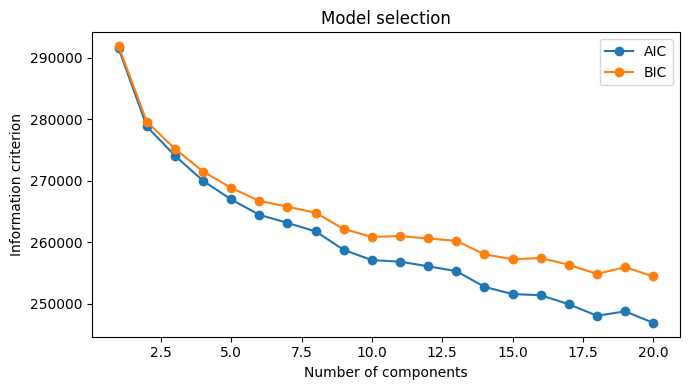

In [ ]:
cluster_count(scaled_pred, pca_components=9, n_fits=20, model="gmm")

100%|██████████| 20/20 [00:00<00:00, 78.01it/s]


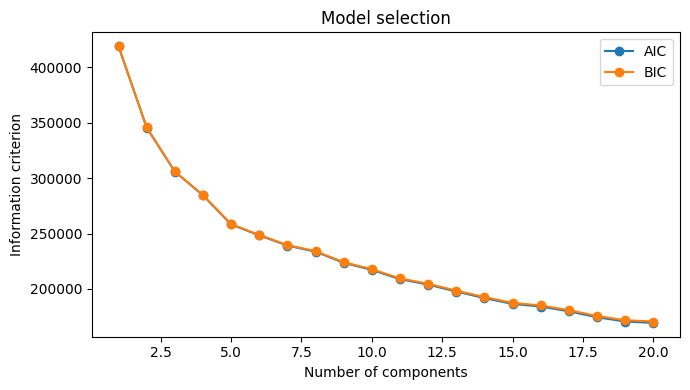

In [ ]:
cluster_count(scaled_pred, pca_components=9, n_fits=20, model="kmeans")

In [ ]:
pca = PCA(n_components=9, random_state=0)
X_pca = pca.fit_transform(scaled_pred)

gmm = GaussianMixture(n_components=10, covariance_type="full", random_state=0)
labels = gmm.fit_predict(X_pca)

calculate_cluster_metrics(gmm, X_pca, labels)

Davies–Bouldin: 2.192939565452439
Calinski–Harabasz: 477.06024169921875
Avg log-likelihood: -17.933674
Mean entropy: 0.15040255
Mean center distance: 7.081587802190921
Cluster frequencies: [0.12288076 0.10312456 0.05198263 0.12119938 0.06038952 0.10985008
 0.10718789 0.07818411 0.18102844 0.06417262]
Std of frequencies: 0.036511911698945756
